In [1]:
import numpy as np 
import pandas as pd 
import os
import torch

In [2]:
# CLONAL EXPANSION
x_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_rna_filtered85.csv'
y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
y = pd.read_csv(y_path)['Y'].values
sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_betaseqs_raw.csv')
sequences['beta'] = sequences['V1']

# # ANTIGEN SPECIFICITY
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv' 
# y = pd.read_csv(y_path)['Antigen'].values - 1
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_seqs.csv', index_col=0)

In [3]:
import sys
sys.path.append('../src/pjm')

from pjm import from_pretrained, build_default_alphabet

alphabet = build_default_alphabet()

# Load encoder
embedder = from_pretrained(
    model_type="mmplm",
    alphabet=alphabet,
    checkpoint_path='../data/pjm_models/mmplm_15epochs_dim256_ckpt.pth',
)

In [4]:
tokenizer = alphabet.get_batch_converter()

batch_labels = sequences['beta'].values
seq_str_list = sequences['beta'].values
raw_batch = list(zip(batch_labels, seq_str_list))

labels, strs, tokens = tokenizer(raw_batch)

In [5]:
embeddings = embedder(tokens)
embeddings.shape

torch.Size([10191, 29, 256])

In [6]:
embeddings = embeddings.detach().numpy()
embeddings = embeddings.reshape(embeddings.shape[0], -1)
embeddings.shape

(10191, 7424)

In [7]:
from sklearn.decomposition import PCA

model = PCA(n_components=32)
model.fit(embeddings)
tcr_embeddings = model.transform(embeddings)
tcr_embeddings.shape

(10191, 32)

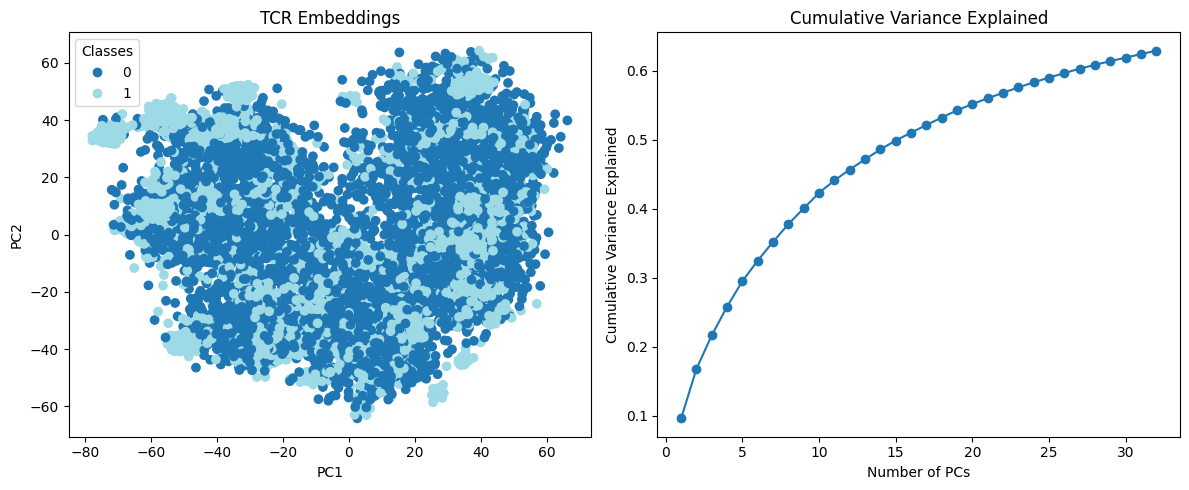

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
scatter = ax[0].scatter(tcr_embeddings[:, 0], tcr_embeddings[:, 1], c=y, cmap='tab20')
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].set_title('TCR Embeddings')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# Cumulative variance explained plot
cumsum_variance = np.cumsum(model.explained_variance_ratio_)
ax[1].plot(range(1, 33), cumsum_variance, marker='o')
ax[1].set_title('Cumulative Variance Explained')
ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Cumulative Variance Explained')

plt.tight_layout()
plt.show()


In [9]:
import sys
sys.path.append('../src')

from interaction import Interaction

machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, y=y,
    interacts_only=False,
    model='LR'
)

beta_interaction = machop.compute(fdr=0.7)
beta_interaction.shape

Found 47 significant values with FDR=0.7


(6, 33)

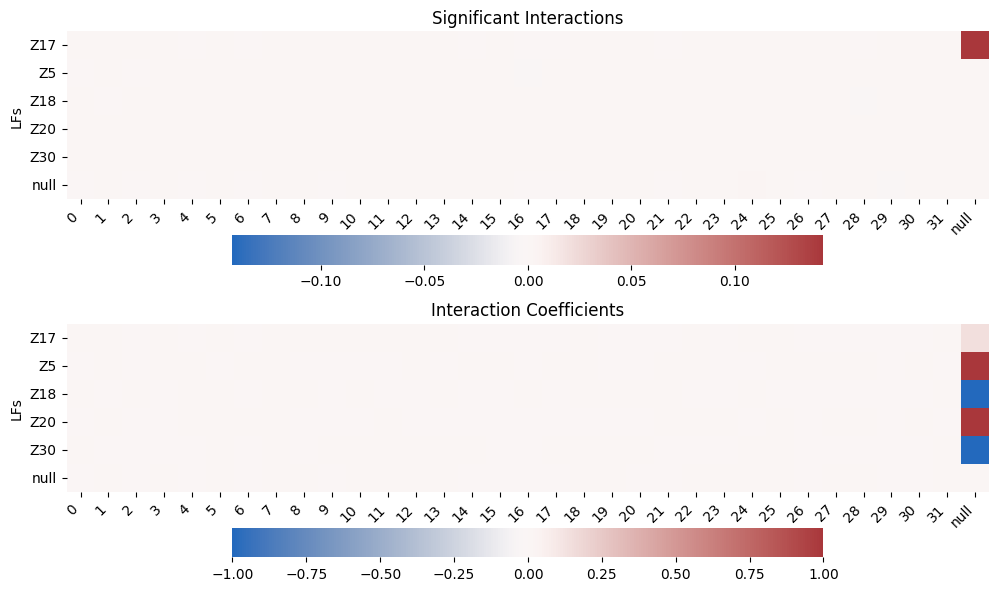

In [10]:
from plotting import show_interactions
show_interactions(machop)

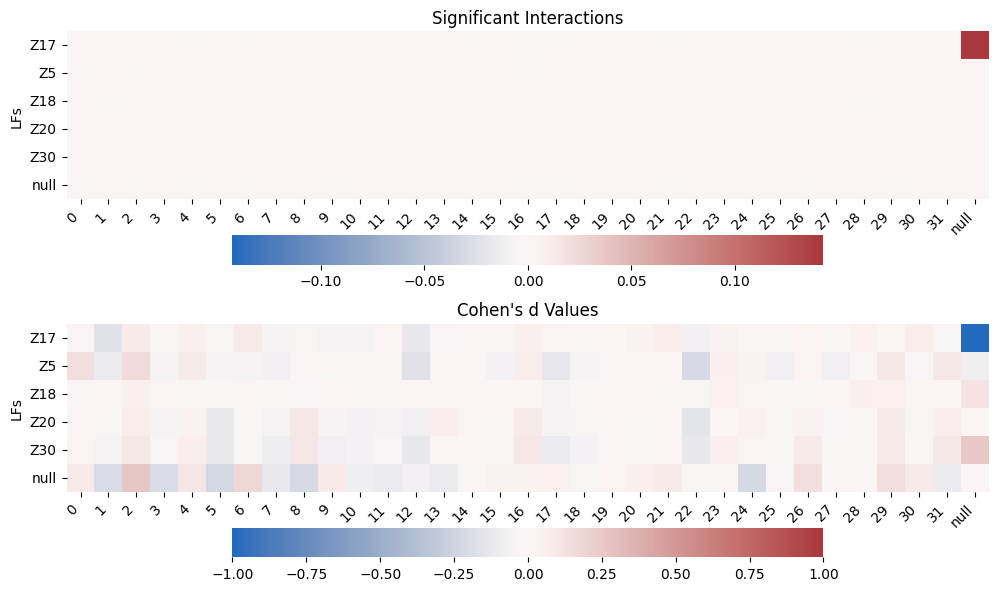

In [11]:
from plotting import show_effect_sizes

machop.filter_effect_size()
show_effect_sizes(machop)

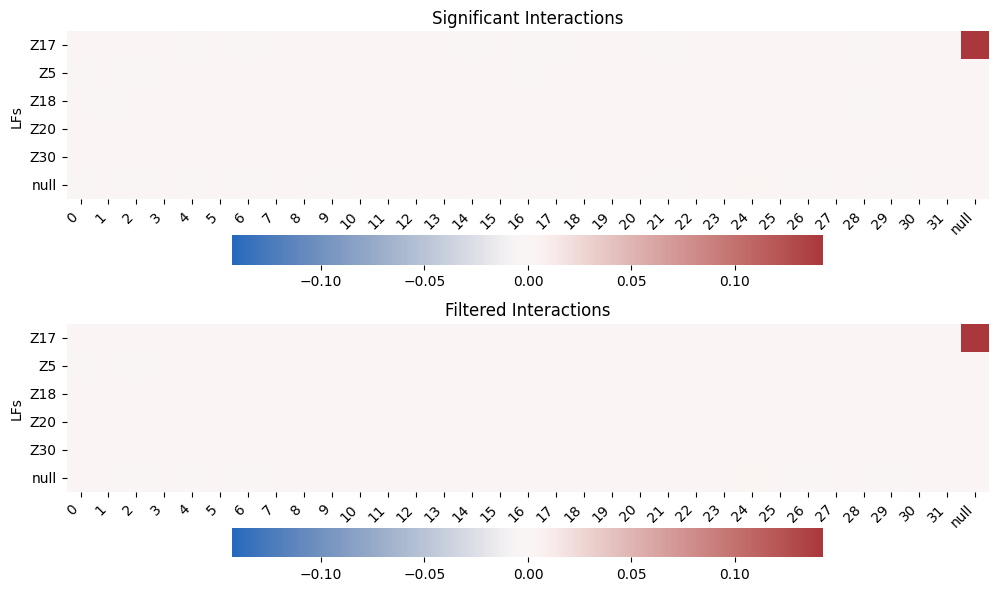

In [12]:
from plotting import show_filtered

machop.filter_by_effect()
show_filtered(machop)

In [13]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()

machop.get_joint_embed(use_filtered=True)
filtered_embed = machop.joint_embed

In [14]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(10191, 39)

In [15]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

In [20]:
model = Lasso(alpha=0.1)
# model = LinearRegression()

In [21]:
estimator = Estimator(model=model)
scores = estimator.evaluate(joint_embed, y)
auc0 = np.mean(scores)

estimator = Estimator(model=model)
scores = estimator.evaluate(filtered_embed, y)
auc1 = np.mean(scores)

estimator = Estimator(model=model)
scores = estimator.evaluate(full_embed, y)
auc2 = np.mean(scores)

estimator = Estimator(model=model)
scores = estimator.evaluate(machop.z_matrix, y)
auc3 = np.mean(scores)

estimator = Estimator(model=model)
scores = estimator.evaluate(machop.plm_embedding, y)
auc4 = np.mean(scores)

embeddings = [joint_embed, filtered_embed, full_embed, machop.z_matrix, machop.plm_embedding]

df = pd.DataFrame({
    'Model': ['Joint', 'Filtered', 'Full', 'Z', 'PLM'],
    'AUC': [auc0, auc1, auc2, auc3, auc4],
    '# Values': [np.sum(np.where(embed != 0, 1, 0)) for embed in embeddings]
})
df

,Model,AUC,# Values
0,Joint,0.500000,326112
1,Filtered,0.500000,203820
2,Full,0.796184,397449
3,Z,0.787469,61146
4,PLM,0.633028,336303
